In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns

from scipy import signal
from scipy.fft import fft

sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

In [2]:
class LowpassFilter:
    def __init__(self, cutoff_freq, sampling_freq):
        """
        Initialize lowpass filter
        
        Args:
            cutoff_freq: Cutoff frequency in Hz
            sampling_freq: Sampling frequency in Hz
        """
        self.fc = cutoff_freq
        self.fs = sampling_freq
        self.reset()
        
        # Calculate filter coefficient (first-order IIR)
        # RC = 1 / (2 * pi * fc)
        # alpha = dt / (RC + dt) where dt = 1/fs
        dt = 1.0 / self.fs
        rc = 1.0 / (2 * np.pi * self.fc)
        self.alpha = dt / (rc + dt)
    
    def reset(self):
        """Reset filter state"""
        self.prev_output = 0.0
    
    def filter_sample(self, input_sample):
        """
        Filter a single sample (real-time processing)
        
        Args:
            input_sample: Input sample value
            
        Returns:
            Filtered output sample
        """
        # y[n] = alpha * x[n] + (1 - alpha) * y[n-1]
        output = self.alpha * input_sample + (1 - self.alpha) * self.prev_output
        self.prev_output = output
        return output
    
    def filter_signal(self, input_signal):
        """
        Filter an entire signal array
        
        Args:
            input_signal: Input signal array
            
        Returns:
            Filtered signal array
        """
        output_signal = np.zeros_like(input_signal)
        self.reset()  # Reset filter state
        
        for i, sample in enumerate(input_signal):
            output_signal[i] = self.filter_sample(sample)
            
        return output_signal

# Alternative using scipy.signal for higher-order filters
def butterworth_lowpass(cutoff_freq, sampling_freq, order=4):
    """
    Create Butterworth lowpass filter using scipy
    
    Args:
        cutoff_freq: Cutoff frequency in Hz
        sampling_freq: Sampling frequency in Hz
        order: Filter order (default: 4)
        
    Returns:
        b, a: Filter coefficients
    """
    nyquist = sampling_freq / 2
    normalized_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)
    return b, a

def apply_butterworth_filter(input_signal, cutoff_freq, sampling_freq, order=4):
    """
    Apply Butterworth lowpass filter to signal
    
    Args:
        input_signal: Input signal array
        cutoff_freq: Cutoff frequency in Hz
        sampling_freq: Sampling frequency in Hz
        order: Filter order (default: 4)
        
    Returns:
        Filtered signal array
    """
    b, a = butterworth_lowpass(cutoff_freq, sampling_freq, order)
    return signal.filtfilt(b, a, input_signal)


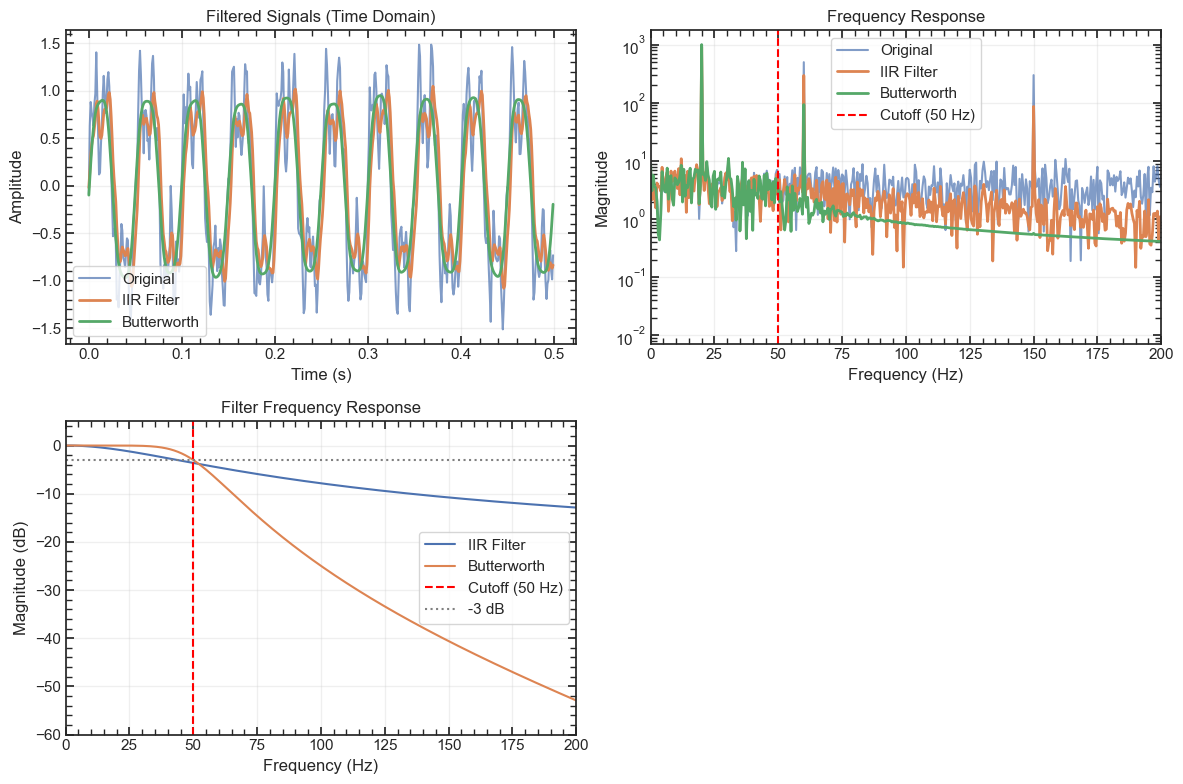

Filter parameters:
Cutoff frequency: 50 Hz
Sampling frequency: 1000 Hz
IIR filter alpha: 0.2391


In [3]:
fs = 1000  # Sampling frequency (Hz)
fc = 50    # Cutoff frequency (Hz)
duration = 2.0  # Signal duration (seconds)

# Create test signal with multiple frequency components
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Signal with 20Hz, 60Hz, and 150Hz components
test_signal = (np.sin(2 * np.pi * 20 * t) + 
                0.5 * np.sin(2 * np.pi * 60 * t) + 
                0.3 * np.sin(2 * np.pi * 150 * t))

# Add some noise
test_signal += 0.1 * np.random.randn(len(t))

# Apply custom IIR filter
lpf = LowpassFilter(fc, fs)
filtered_iir = lpf.filter_signal(test_signal)

# Apply Butterworth filter
filtered_butter = apply_butterworth_filter(test_signal, fc, fs, order=4)

# Plot results
plt.figure(figsize=(12, 8))

# Time domain
plt.subplot(2, 2, 1)
plt.plot(t[:500], test_signal[:500], label='Original', alpha=0.7)
plt.plot(t[:500], filtered_iir[:500], label='IIR Filter', linewidth=2)
plt.plot(t[:500], filtered_butter[:500], label='Butterworth', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Signals (Time Domain)')
plt.legend()
plt.grid(True, alpha=0.3)

# Frequency domain
plt.subplot(2, 2, 2)
freqs = np.fft.fftfreq(len(test_signal), 1/fs)
freqs = freqs[:len(freqs)//2]

fft_orig = np.abs(np.fft.fft(test_signal))[:len(freqs)]
fft_iir = np.abs(np.fft.fft(filtered_iir))[:len(freqs)]
fft_butter = np.abs(np.fft.fft(filtered_butter))[:len(freqs)]

plt.semilogy(freqs, fft_orig, label='Original', alpha=0.7)
plt.semilogy(freqs, fft_iir, label='IIR Filter', linewidth=2)
plt.semilogy(freqs, fft_butter, label='Butterworth', linewidth=2)
plt.axvline(fc, color='red', linestyle='--', label=f'Cutoff ({fc} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Response')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 200)

# Filter frequency response
plt.subplot(2, 2, 3)
b_iir, a_iir = [lpf.alpha], [1, -(1-lpf.alpha)]
w_iir, h_iir = signal.freqz(b_iir, a_iir, worN=1024, fs=fs)

b_butter, a_butter = butterworth_lowpass(fc, fs, order=4)
w_butter, h_butter = signal.freqz(b_butter, a_butter, worN=1024, fs=fs)

plt.plot(w_iir, 20 * np.log10(abs(h_iir)), label='IIR Filter')
plt.plot(w_butter, 20 * np.log10(abs(h_butter)), label='Butterworth')
plt.axvline(fc, color='red', linestyle='--', label=f'Cutoff ({fc} Hz)')
plt.axhline(-3, color='gray', linestyle=':', label='-3 dB')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Filter Frequency Response')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 200)
plt.ylim(-60, 5)

plt.tight_layout()
plt.show()

print(f"Filter parameters:")
print(f"Cutoff frequency: {fc} Hz")
print(f"Sampling frequency: {fs} Hz")
print(f"IIR filter alpha: {lpf.alpha:.4f}")

--------

In [4]:
def spectrum(wf, points=int(1000), fs=1):
    """
    Computes the frequency spectrum of a waveform.
    
    Args:
        wf (array): waveform
        points (int): number of points in the psd
        fs (int): sampling frequency
        
    Returns:
        array: frequency
        array: amplitude
        array: phase
    """
    spect = fft(wf, n=2*(points-1), axis=0)
    amp = np.abs(spect/fs/len(wf))
    amp = amp[:int(len(spect)/2+1)]
    amp[1:] = 2*amp[1:]
    phase = np.angle(spect[:int(len(spect)/2+1)])
    freq = np.arange(0, fs/2, fs/2/len(amp))
    return freq, amp, phase

def design_fir_lowpass(cutoff_freq, sampling_freq, num_taps=11, window='hamming'):
    """
    Design a FIR lowpass filter
    
    Args:
        cutoff_freq (float): Cutoff frequency in Hz
        sampling_freq (float): Sampling frequency in Hz
        num_taps (int): Number of filter taps (filter length)
        window (str): Window function ('hamming', 'hann', 'blackman', etc.)
        
    Returns:
        array: Filter coefficients
    """
    # Normalize cutoff frequency (0 to 1, where 1 is Nyquist frequency)
    nyquist = sampling_freq / 2
    normalized_cutoff = cutoff_freq / nyquist
    
    # Design FIR filter
    filter_coeffs = signal.firwin(numtaps=num_taps, cutoff=normalized_cutoff, window=window)
    
    return filter_coeffs

def analyze_filter_response(filter_coeffs, sampling_freq, points=1000):
    """
    Analyze filter frequency response using both custom spectrum function and scipy
    
    Args:
        filter_coeffs (array): Filter coefficients
        sampling_freq (float): Sampling frequency in Hz
        points (int): Number of frequency points for analysis
        
    Returns:
        dict: Dictionary containing frequency response data
    """
    # Method 1: Using custom spectrum function
    freq_custom, amp_custom, phase_custom = spectrum(filter_coeffs, points=points, fs=sampling_freq)
    
    # Method 2: Using scipy.signal.freqz (more accurate for filter analysis)
    w, h = signal.freqz(filter_coeffs, worN=points, fs=sampling_freq)
    amp_scipy = np.abs(h)
    phase_scipy = np.angle(h)
    
    return {
        'freq_custom': freq_custom,
        'amp_custom': amp_custom,
        'phase_custom': phase_custom,
        'freq_scipy': w,
        'amp_scipy': amp_scipy,
        'phase_scipy': phase_scipy
    }

def apply_fir_filter(signal_data, filter_coeffs):
    """
    Apply FIR filter to signal
    
    Args:
        signal_data (array): Input signal
        filter_coeffs (array): Filter coefficients
        
    Returns:
        array: Filtered signal
    """
    return signal.lfilter(filter_coeffs, 1.0, signal_data)

    

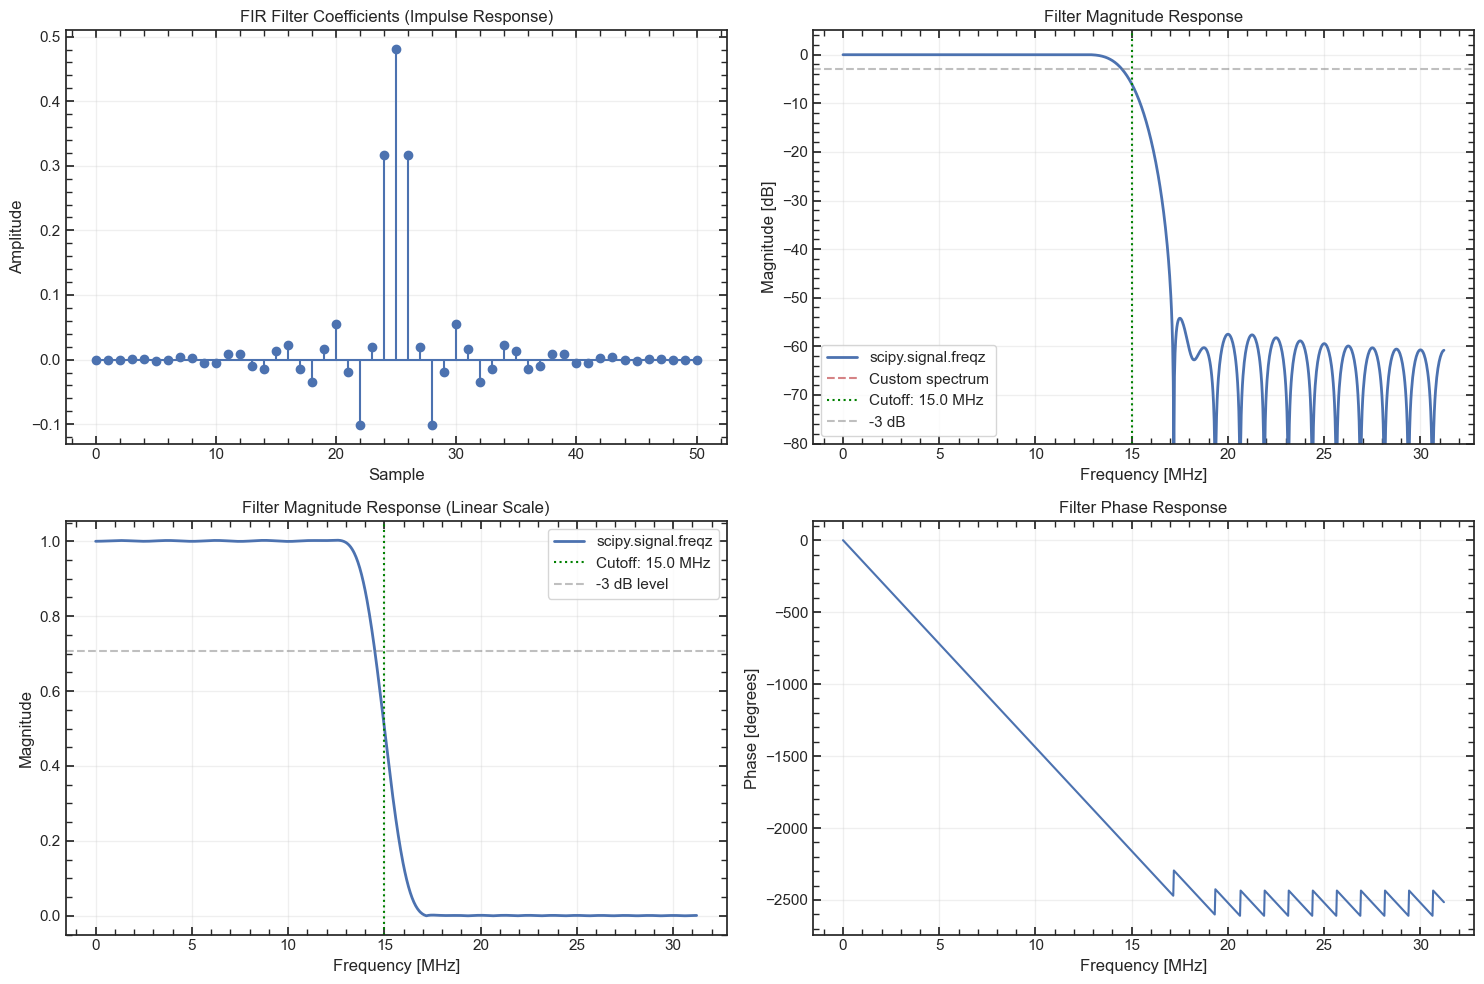

Filter Analysis:
Cutoff frequency: 15.0 MHz
Sampling frequency: 62.5 MHz
Normalized cutoff: 0.480
Filter length: 51 taps
Filter coefficients: [-1.49844196e-18 -1.10809381e-03 -1.64000906e-04  1.59773344e-03
  5.16578973e-04 -2.54332097e-03 -1.26357966e-03  3.95284347e-03
  2.65039852e-03 -5.78663514e-03 -4.96760459e-03  7.95827257e-03
  8.57585873e-03 -1.03405440e-02 -1.39763944e-02  1.27760037e-02
  2.19968650e-02 -1.50910953e-02 -3.43180406e-02  1.71124029e-02
  5.52839917e-02 -1.86833273e-02 -1.00961217e-01  1.96794062e-02
  3.16855951e-01  4.80495095e-01  3.16855951e-01  1.96794062e-02
 -1.00961217e-01 -1.86833273e-02  5.52839917e-02  1.71124029e-02
 -3.43180406e-02 -1.50910953e-02  2.19968650e-02  1.27760037e-02
 -1.39763944e-02 -1.03405440e-02  8.57585873e-03  7.95827257e-03
 -4.96760459e-03 -5.78663514e-03  2.65039852e-03  3.95284347e-03
 -1.26357966e-03 -2.54332097e-03  5.16578973e-04  1.59773344e-03
 -1.64000906e-04 -1.10809381e-03 -1.49844196e-18]


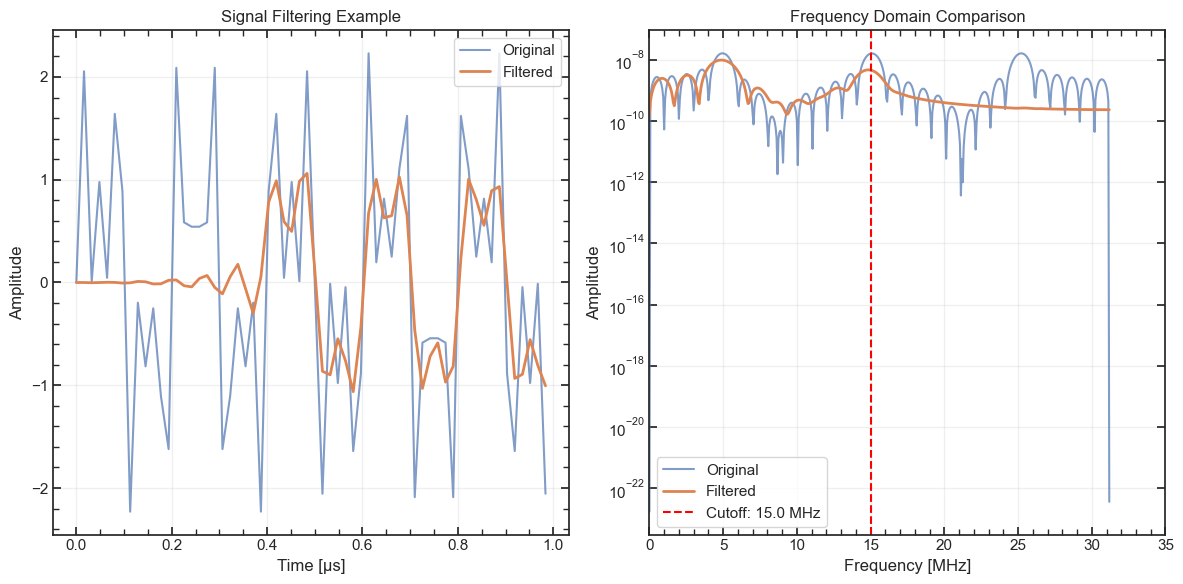

In [5]:
# Filter parameters
f_h = 15e6  # Hz - cutoff frequency
f_s = 62.5e6  # Hz - sampling frequency
w_h = 2 * np.pi * f_h
w_s = 2 * np.pi * f_s
low_len = 51  # Length of the FIR filter

# Design the filter
filter_coeffs = design_fir_lowpass(f_h, f_s, low_len, 'hamming')

# Analyze filter response
response_data = analyze_filter_response(filter_coeffs, f_s, points=1000)

# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Filter coefficients (impulse response)
axes[0, 0].stem(range(len(filter_coeffs)), filter_coeffs, basefmt='b-')
axes[0, 0].set_title('FIR Filter Coefficients (Impulse Response)')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Magnitude response (dB scale)
axes[0, 1].plot(response_data['freq_scipy']/1e6, 20*np.log10(response_data['amp_scipy']), 
                'b-', label='scipy.signal.freqz', linewidth=2)
axes[0, 1].plot(response_data['freq_custom'][1:]/1e6, 20*np.log10(response_data['amp_custom'][1:]), 
                'r--', label='Custom spectrum', alpha=0.7)
axes[0, 1].axvline(f_h/1e6, color='green', linestyle=':', label=f'Cutoff: {f_h/1e6:.1f} MHz')
axes[0, 1].axhline(-3, color='gray', linestyle='--', alpha=0.5, label='-3 dB')
axes[0, 1].set_title('Filter Magnitude Response')
axes[0, 1].set_xlabel('Frequency [MHz]')
axes[0, 1].set_ylabel('Magnitude [dB]')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(-80, 5)

# Plot 3: Linear magnitude response
axes[1, 0].plot(response_data['freq_scipy']/1e6, response_data['amp_scipy'], 
                'b-', label='scipy.signal.freqz', linewidth=2)
axes[1, 0].axvline(f_h/1e6, color='green', linestyle=':', label=f'Cutoff: {f_h/1e6:.1f} MHz')
axes[1, 0].axhline(1/np.sqrt(2), color='gray', linestyle='--', alpha=0.5, label='-3 dB level')
axes[1, 0].set_title('Filter Magnitude Response (Linear Scale)')
axes[1, 0].set_xlabel('Frequency [MHz]')
axes[1, 0].set_ylabel('Magnitude')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Phase response
axes[1, 1].plot(response_data['freq_scipy']/1e6, np.unwrap(response_data['phase_scipy'])*180/np.pi)
axes[1, 1].set_title('Filter Phase Response')
axes[1, 1].set_xlabel('Frequency [MHz]')
axes[1, 1].set_ylabel('Phase [degrees]')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test filter with a signal
print("Filter Analysis:")
print(f"Cutoff frequency: {f_h/1e6:.1f} MHz")
print(f"Sampling frequency: {f_s/1e6:.1f} MHz")
print(f"Normalized cutoff: {f_h/(f_s/2):.3f}")
print(f"Filter length: {low_len} taps")
print(f"Filter coefficients: {filter_coeffs}")

# Create test signal and demonstrate filtering
duration = 1e-6  # 1 microsecond
t = np.linspace(0, duration, int(f_s * duration), endpoint=False)

# Test signal with frequencies at 5MHz, 15MHz (cutoff), and 25MHz
test_signal = (np.sin(2 * np.pi * 5e6 * t) + 
                np.sin(2 * np.pi * 15e6 * t) + 
                np.sin(2 * np.pi * 25e6 * t))

# Apply filter
filtered_signal = apply_fir_filter(test_signal, filter_coeffs)

# Plot test signal results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t*1e6, test_signal, label='Original', alpha=0.7)
plt.plot(t*1e6, filtered_signal, label='Filtered', linewidth=2)
plt.xlabel('Time [μs]')
plt.ylabel('Amplitude')
plt.title('Signal Filtering Example')
plt.legend()
plt.grid(True, alpha=0.3)

# Frequency domain comparison
plt.subplot(1, 2, 2)
freq_orig, amp_orig, _ = spectrum(test_signal, points=500, fs=f_s)
freq_filt, amp_filt, _ = spectrum(filtered_signal, points=500, fs=f_s)

plt.semilogy(freq_orig/1e6, amp_orig, label='Original', alpha=0.7)
plt.semilogy(freq_filt/1e6, amp_filt, label='Filtered', linewidth=2)
plt.axvline(f_h/1e6, color='red', linestyle='--', label=f'Cutoff: {f_h/1e6:.1f} MHz')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 35)

plt.tight_layout()
plt.show()

-----------

In [6]:
class CSAFrequencyModel:
    """
    Frequency response model for Charge Sensitive Amplifier
    """
    
    def __init__(self, Rf, Cf, GBW=None, Cd=None):
        """
        Initialize CSA frequency model
        
        Args:
            Rf (float): Feedback resistance [Ohms]
            Cf (float): Feedback capacitance [F]
            GBW (float, optional): Gain-bandwidth product of amplifier [Hz]
            Cd (float, optional): Detector capacitance [F]
        """
        self.Rf = Rf
        self.Cf = Cf
        self.GBW = GBW
        self.Cd = Cd
        
        # Calculate key frequencies
        self.f_low = 1 / (2 * np.pi * Rf * Cf)  # Low frequency pole
        if GBW:
            # High frequency limitation (simplified)
            # Actual gain at DC is approximately Cd/Cf for charge input
            if Cd:
                self.dc_gain = Cd / Cf
                self.f_high = GBW / self.dc_gain
            else:
                self.f_high = GBW / 100  # Assume some reasonable gain
        else:
            self.f_high = None
    
    def transfer_function_s(self, s):
        """
        Transfer function in s-domain for charge input to voltage output
        H(s) = -1/(Cf) * (sRf)/(1 + sRfCf)
        
        For current input: H(s) = -Rf/(1 + sRfCf)
        """
        # For charge input (most common case)
        numerator = -s * self.Rf / self.Cf
        denominator = 1 + s * self.Rf * self.Cf
        return numerator / denominator
    
    def frequency_response(self, frequencies):
        """
        Calculate frequency response
        
        Args:
            frequencies (array): Frequency array [Hz]
            
        Returns:
            tuple: (magnitude, phase) arrays
        """
        omega = 2 * np.pi * frequencies
        s = 1j * omega
        H = self.transfer_function_s(s)
        
        magnitude = np.abs(H)
        phase = np.angle(H) * 180 / np.pi
        
        return magnitude, phase
    
    def equivalent_filter_coefficients(self, fs, filter_type='analog'):
        """
        Get equivalent digital filter coefficients
        
        Args:
            fs (float): Sampling frequency [Hz]
            filter_type (str): 'analog' or 'digital'
            
        Returns:
            tuple: (b, a) filter coefficients
        """
        if filter_type == 'analog':
            # Analog transfer function coefficients
            # H(s) = s*tau / (1 + s*tau) where tau = RfCf
            tau = self.Rf * self.Cf
            b = [tau, 0]  # s*tau
            a = [tau, 1]  # 1 + s*tau
            return b, a
        
        elif filter_type == 'digital':
            # Convert to digital using bilinear transform
            tau = self.Rf * self.Cf
            # Analog coefficients: H(s) = s*tau / (1 + s*tau)
            b_analog = [tau, 0]
            a_analog = [tau, 1]
            
            # Bilinear transform
            b_digital, a_digital = signal.bilinear(b_analog, a_analog, fs)
            return b_digital, a_digital

def design_csa_equivalent_filter(Rf, Cf, fs, method='bilinear'):
    """
    Design digital filter equivalent to CSA frequency response
    
    Args:
        Rf (float): Feedback resistance [Ohms]
        Cf (float): Feedback capacitance [F]  
        fs (float): Sampling frequency [Hz]
        method (str): Transform method ('bilinear', 'impulse_invariant')
        
    Returns:
        tuple: (b, a) digital filter coefficients
    """
    # CSA has high-pass characteristic due to RfCf feedback
    tau = Rf * Cf
    fc = 1 / (2 * np.pi * tau)  # Corner frequency
    
    if method == 'bilinear':
        # Analog transfer function: H(s) = s*tau / (1 + s*tau)
        b_analog = [tau, 0]
        a_analog = [tau, 1]
        b, a = signal.bilinear(b_analog, a_analog, fs)
        
    elif method == 'impulse_invariant':
        # For impulse invariant, we need to be more careful
        # The CSA response is essentially a high-pass filter
        # We can approximate with a high-pass Butterworth
        nyquist = fs / 2
        normalized_fc = fc / nyquist
        b, a = signal.butter(1, normalized_fc, btype='high', analog=False)
    
    return b, a

def apply_csa_filter(signal_data, Rf, Cf, fs):
    """
    Apply CSA frequency response to signal
    
    Args:
        signal_data (array): Input signal (charge or current)
        Rf (float): Feedback resistance [Ohms]
        Cf (float): Feedback capacitance [F]
        fs (float): Sampling frequency [Hz]
        
    Returns:
        array: Filtered signal (voltage output)
    """
    b, a = design_csa_equivalent_filter(Rf, Cf, fs)
    return signal.lfilter(b, a, signal_data)



CSA Analysis:
Feedback RC time constant: 1000.0 μs
Low frequency corner: 159.15 Hz
High frequency corner: 1.0 MHz
DC gain (charge to voltage): 10.0


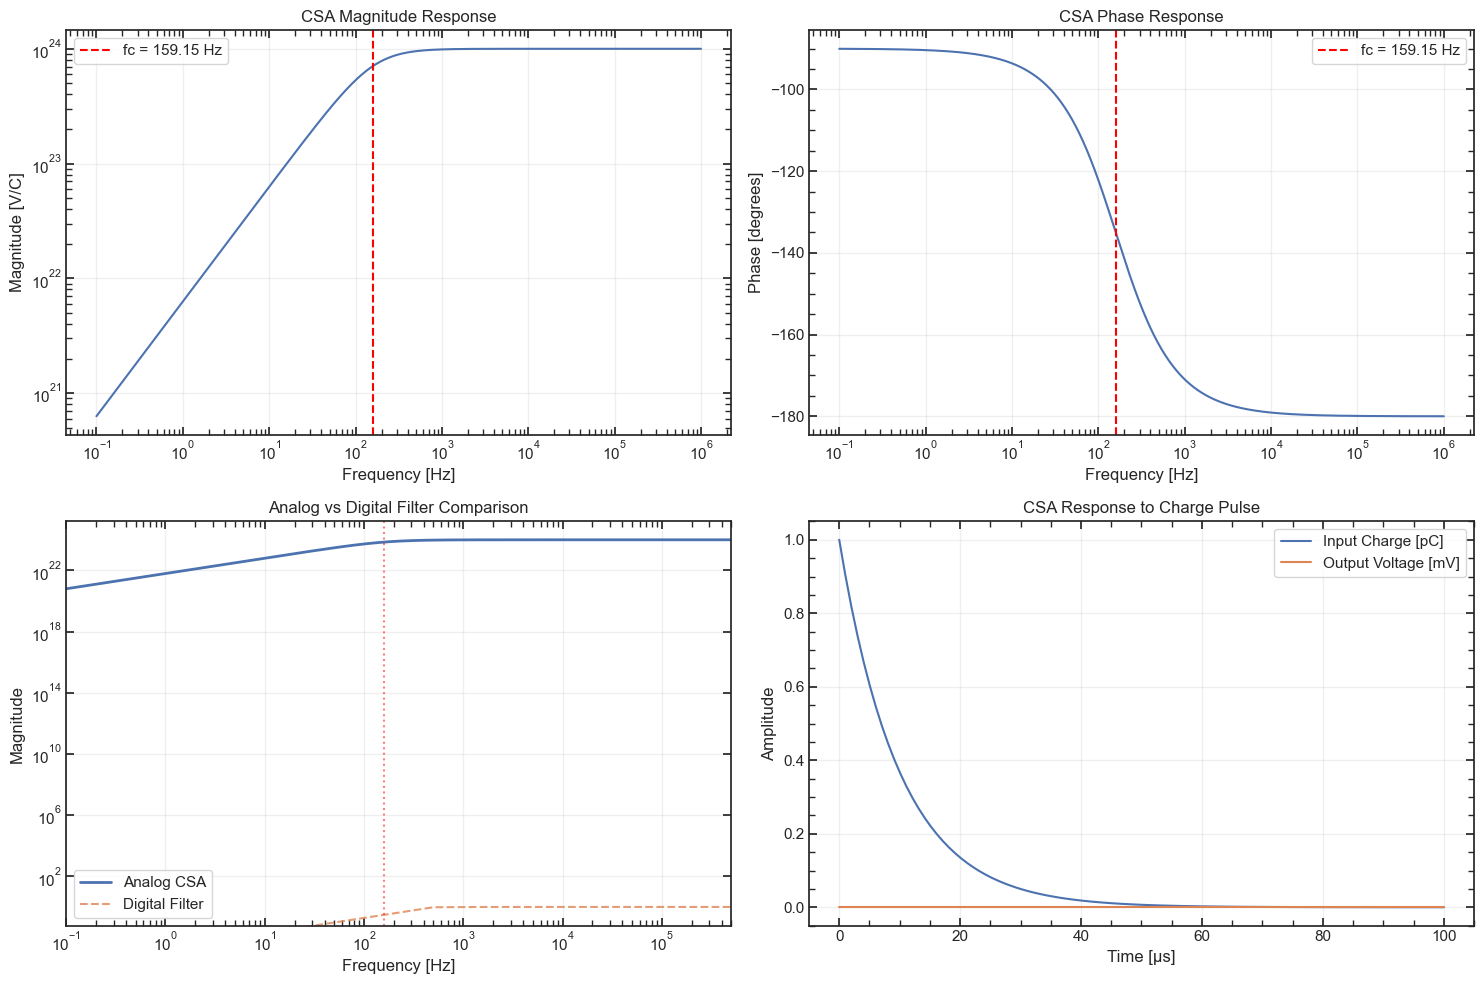

In [7]:

# Typical CSA parameters
Rf = 1e9    # 1 GOhm feedback resistor
Cf = 1e-12  # 1 pF feedback capacitor
GBW = 10e6  # 10 MHz gain-bandwidth product
Cd = 10e-12 # 10 pF detector capacitance
fs = 1e6    # 1 MHz sampling frequency

# Create CSA model
csa = CSAFrequencyModel(Rf, Cf, GBW, Cd)

print(f"CSA Analysis:")
print(f"Feedback RC time constant: {Rf*Cf*1e6:.1f} μs")
print(f"Low frequency corner: {csa.f_low:.2f} Hz")
if csa.f_high:
    print(f"High frequency corner: {csa.f_high/1e6:.1f} MHz")
print(f"DC gain (charge to voltage): {csa.dc_gain:.1f}")

# Frequency analysis
frequencies = np.logspace(-1, 6, 1000)  # 0.1 Hz to 1 MHz
magnitude, phase = csa.frequency_response(frequencies)

# Plot frequency response
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Magnitude response
axes[0, 0].loglog(frequencies, magnitude)
axes[0, 0].axvline(csa.f_low, color='red', linestyle='--', 
                    label=f'fc = {csa.f_low:.2f} Hz')
axes[0, 0].set_xlabel('Frequency [Hz]')
axes[0, 0].set_ylabel('Magnitude [V/C]')
axes[0, 0].set_title('CSA Magnitude Response')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Phase response
axes[0, 1].semilogx(frequencies, phase)
axes[0, 1].axvline(csa.f_low, color='red', linestyle='--',
                    label=f'fc = {csa.f_low:.2f} Hz')
axes[0, 1].set_xlabel('Frequency [Hz]')
axes[0, 1].set_ylabel('Phase [degrees]')
axes[0, 1].set_title('CSA Phase Response')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Digital filter comparison
b, a = design_csa_equivalent_filter(Rf, Cf, fs)
w_digital, h_digital = signal.freqz(b, a, worN=1000, fs=fs)

axes[1, 0].loglog(frequencies, magnitude, label='Analog CSA', linewidth=2)
axes[1, 0].loglog(w_digital, np.abs(h_digital), '--', 
                    label='Digital Filter', alpha=0.8)
axes[1, 0].axvline(csa.f_low, color='red', linestyle=':', alpha=0.5)
axes[1, 0].set_xlabel('Frequency [Hz]')
axes[1, 0].set_ylabel('Magnitude')
axes[1, 0].set_title('Analog vs Digital Filter Comparison')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(0.1, fs/2)

# Test with pulse signal
# Generate test charge pulse (exponential decay)
t = np.linspace(0, 100e-6, 100)  # 100 μs
tau_pulse = 10e-6  # 10 μs decay time
charge_pulse = 1e-12 * np.exp(-t/tau_pulse)  # 1 pC pulse

# Apply CSA filter
voltage_output = apply_csa_filter(charge_pulse, Rf, Cf, 1/np.mean(np.diff(t)))

axes[1, 1].plot(t*1e6, charge_pulse*1e12, label='Input Charge [pC]')
axes[1, 1].plot(t*1e6, voltage_output*1e3, label='Output Voltage [mV]')
axes[1, 1].set_xlabel('Time [μs]')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_title('CSA Response to Charge Pulse')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--------

In [8]:
class CSAHighPassFilter:
    """
    High-pass filter implementation for Charge Sensitive Amplifier frequency effects
    """
    
    def __init__(self, Rf, Cf, sampling_freq):
        """
        Initialize CSA high-pass filter
        
        Args:
            Rf (float): Feedback resistance [Ohms]
            Cf (float): Feedback capacitance [F]
            sampling_freq (float): Sampling frequency [Hz]
        """
        self.Rf = Rf
        self.Cf = Cf
        self.fs = sampling_freq
        self.tau = Rf * Cf  # RC time constant
        self.fc = 1 / (2 * np.pi * self.tau)  # Corner frequency
        
        # Design digital filter coefficients
        self.b, self.a = self._design_filter()
        
        # Initialize filter state for real-time processing
        self.zi = None
        
    def _design_filter(self):
        """
        Design digital high-pass filter using bilinear transform
        
        Returns:
            tuple: (b, a) digital filter coefficients
        """
        # Analog transfer function: H(s) = s*tau / (1 + s*tau)
        # This represents the CSA's charge-to-voltage transfer function
        tau = self.tau
        
        # Analog coefficients
        b_analog = [tau, 0]      # s*tau (numerator)
        a_analog = [tau, 1]      # 1 + s*tau (denominator)
        
        # Convert to digital using bilinear transform
        b_digital, a_digital = signal.bilinear(b_analog, a_analog, self.fs)
        
        return b_digital, a_digital
    
    def filter_signal(self, input_signal):
        """
        Apply high-pass filter to entire signal array
        
        Args:
            input_signal (array): Input signal from CSA simulation
            
        Returns:
            array: Filtered signal accounting for frequency effects
        """
        # Apply filter using scipy's lfilter
        filtered_signal = signal.lfilter(self.b, self.a, input_signal)
        return filtered_signal
    
    def filter_signal_realtime_init(self):
        """
        Initialize filter state for real-time processing
        """
        self.zi = signal.lfilter_zi(self.b, self.a)
    
    def filter_sample_realtime(self, input_sample):
        """
        Filter single sample (for real-time simulation)
        
        Args:
            input_sample (float): Single input sample
            
        Returns:
            float: Filtered output sample
        """
        if self.zi is None:
            self.filter_signal_realtime_init()
        
        output_sample, self.zi = signal.lfilter(self.b, self.a, [input_sample], zi=self.zi)
        return output_sample[0]
    
    def get_frequency_response(self, frequencies=None):
        """
        Get filter frequency response
        
        Args:
            frequencies (array, optional): Frequency points for analysis
            
        Returns:
            tuple: (frequencies, magnitude, phase)
        """
        if frequencies is None:
            frequencies = np.logspace(-1, np.log10(self.fs/2), 1000)
        
        # Get digital filter response
        w, h = signal.freqz(self.b, self.a, worN=frequencies, fs=self.fs)
        magnitude = np.abs(h)
        phase = np.angle(h) * 180 / np.pi
        
        return w, magnitude, phase
    
    def plot_filter_response(self):
        """
        Plot filter frequency response
        """
        freq, mag, phase = self.get_frequency_response()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Magnitude response
        ax1.loglog(freq, mag)
        ax1.axvline(self.fc, color='red', linestyle='--', 
                   label=f'fc = {self.fc:.2f} Hz')
        ax1.axhline(1/np.sqrt(2), color='gray', linestyle=':', 
                   label='-3 dB level')
        ax1.set_xlabel('Frequency [Hz]')
        ax1.set_ylabel('Magnitude')
        ax1.set_title(f'CSA High-Pass Filter Response (Rf={self.Rf/1e9:.0f}GΩ, Cf={self.Cf*1e15:.0f}fF)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Phase response
        ax2.semilogx(freq, phase)
        ax2.axvline(self.fc, color='red', linestyle='--')
        ax2.set_xlabel('Frequency [Hz]')
        ax2.set_ylabel('Phase [degrees]')
        ax2.set_title('Phase Response')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def apply_csa_frequency_effects(signal_data, Rf, Cf, sampling_freq):
    """
    Simple function to apply CSA frequency effects to simulation results
    
    Args:
        signal_data (array): Output from your CSA simulation
        Rf (float): Feedback resistance [Ohms]
        Cf (float): Feedback capacitance [F]
        sampling_freq (float): Sampling frequency [Hz]
        
    Returns:
        array: Signal with frequency effects applied
    """
    # Create filter
    csa_filter = CSAHighPassFilter(Rf, Cf, sampling_freq)
    
    # Apply filter
    filtered_signal = csa_filter.filter_signal(signal_data)
    
    return filtered_signal



CSA Parameters:
Rf = 1 GΩ
Cf = 400 fF
RC time constant = 400.0 μs
Corner frequency = 397.89 Hz
Sampling frequency = 62.5 MHz (16 ns period)
Oversampling ratio = 0.2 million


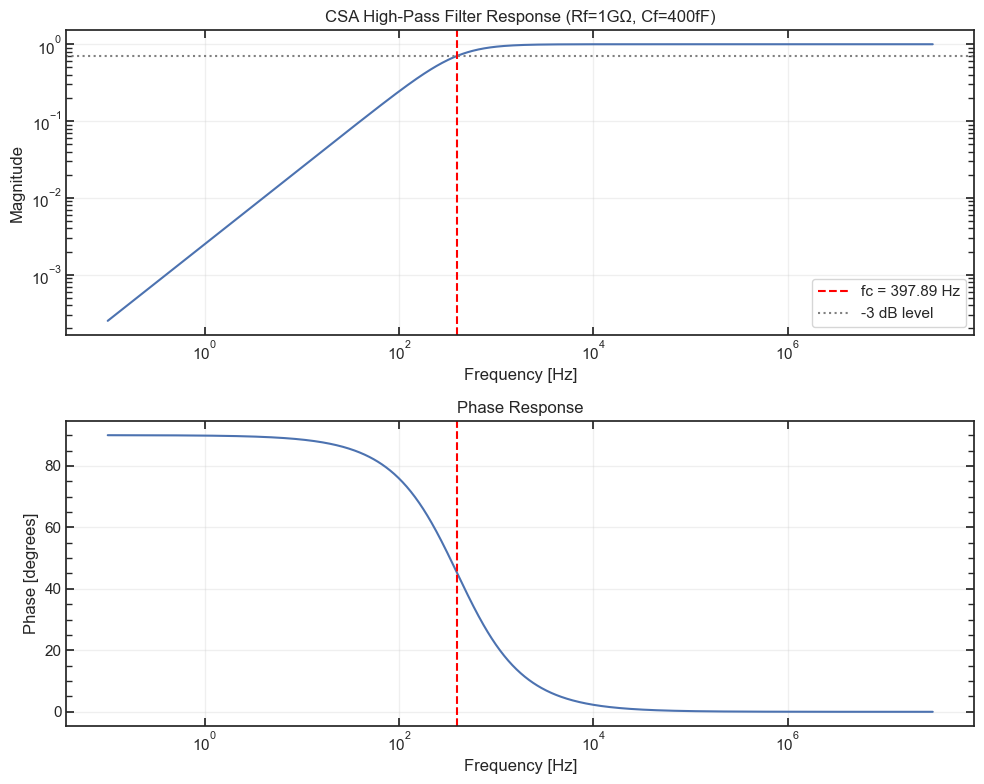


Simulation details:
Time window: 10 μs
Number of samples: 625
Time resolution: 16.0 ns


/var/folders/0d/wr4vslms6rx70gkgwp1_dz400000gn/T/ipykernel_56385/3642011276.py:98: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i, 1].axvline(fc, color='red', linestyle='--', alpha=0.7)


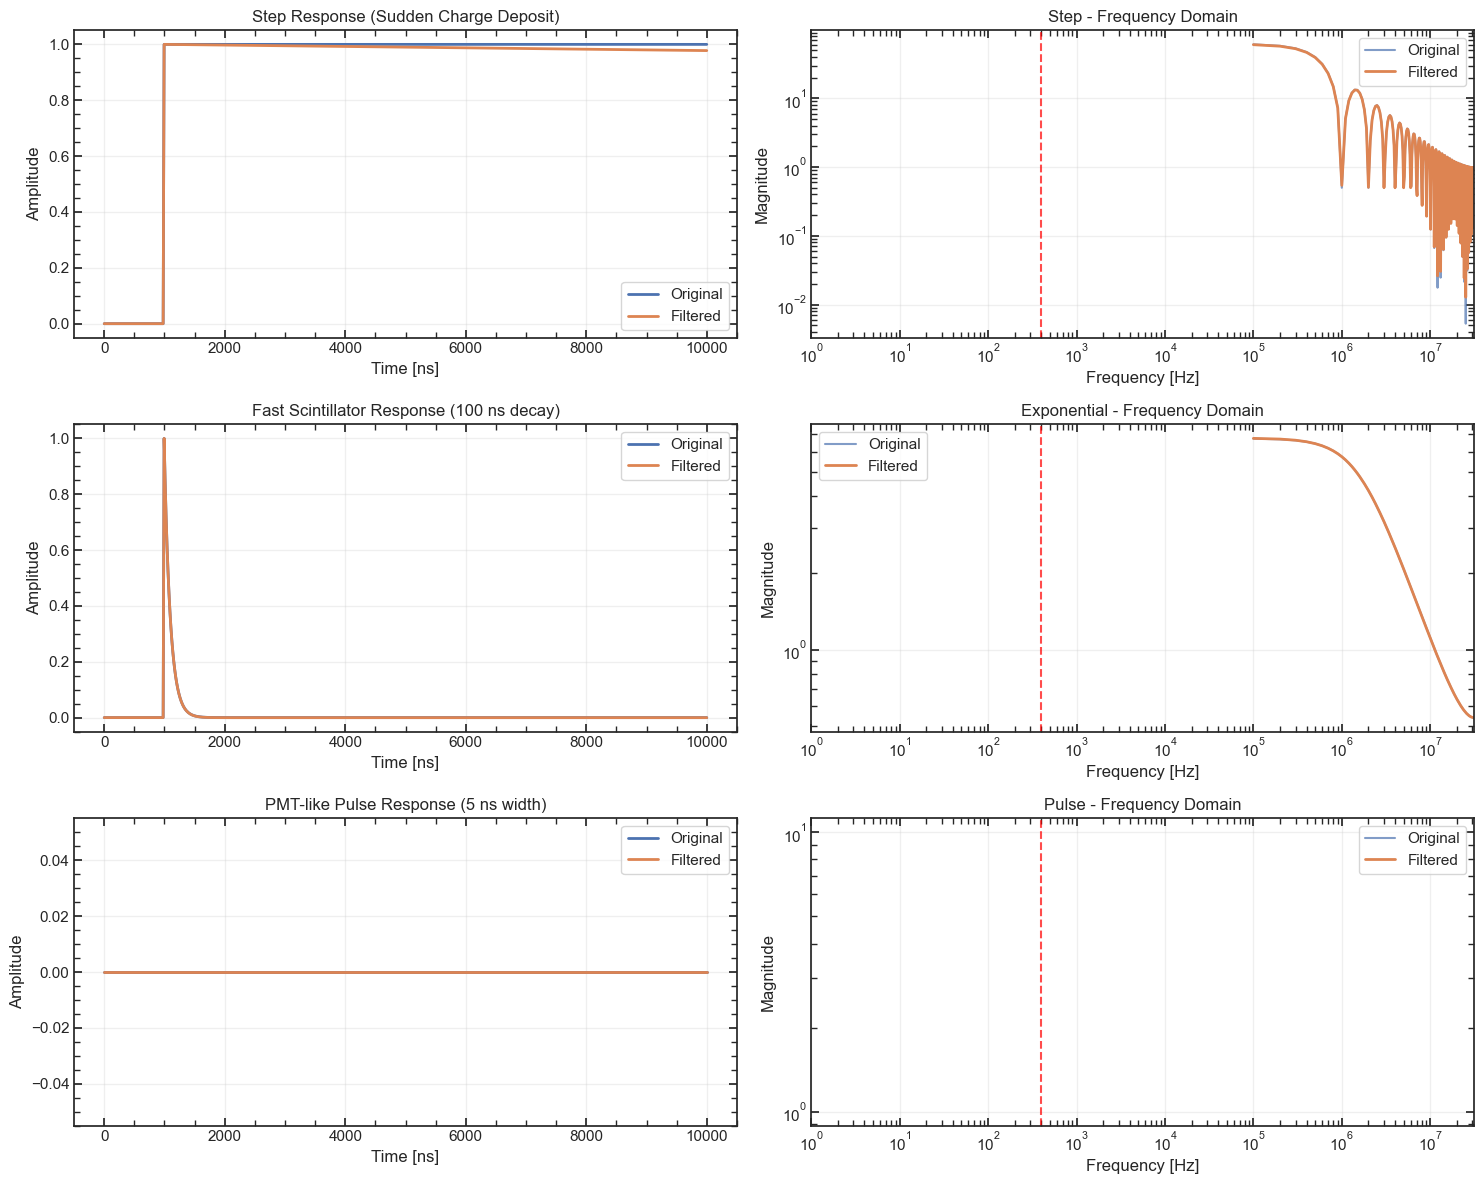


How to use in your simulation:
# After getting your ideal CSA output:
realistic_output = apply_csa_frequency_effects(ideal_output, Rf=1e9, Cf=400e-15, sampling_freq=62.5e6)

# Or for real-time processing:
csa_filter = CSAHighPassFilter(Rf=1e9, Cf=400e-15, sampling_freq=62.5e6)
csa_filter.filter_signal_realtime_init()
filtered_sample = csa_filter.filter_sample_realtime(input_sample)

Expected behavior with your parameters:
- Corner frequency: 397.89 Hz (extremely low)
- Fast pulses (ns-μs range): Minimal attenuation
- DC/slow drifts: Completely blocked
- Step responses: Will show brief spike then exponential decay
- Your 16 ns sampling provides excellent time resolution


In [9]:
Rf = 1e9      # 1 GΩ
Cf = 400e-15  # 400 fF
fs = 62.5e6   # 62.5 MHz sampling (16 ns sampling period)

# Calculate key characteristics
tau = Rf * Cf
fc = 1 / (2 * np.pi * tau)

print(f"CSA Parameters:")
print(f"Rf = {Rf/1e9:.0f} GΩ")
print(f"Cf = {Cf*1e15:.0f} fF")
print(f"RC time constant = {tau*1e6:.1f} μs")
print(f"Corner frequency = {fc:.2f} Hz")
print(f"Sampling frequency = {fs/1e6:.1f} MHz (16 ns period)")
print(f"Oversampling ratio = {fs/fc/1e6:.1f} million")

# Create filter
csa_filter = CSAHighPassFilter(Rf, Cf, fs)

# Plot filter response
csa_filter.plot_filter_response()

# Demonstration with test signals - using realistic detector timescales
# Create time vector for typical detector pulse analysis
duration = 10e-6  # 10 μs (realistic for detector pulses)
t = np.linspace(0, duration, int(fs * duration))

print(f"\nSimulation details:")
print(f"Time window: {duration*1e6:.0f} μs")
print(f"Number of samples: {len(t):,}")
print(f"Time resolution: {1/fs*1e9:.1f} ns")

# Test signal 1: Step function (simulates sudden charge deposit)
step_signal = np.ones_like(t)
step_signal[:len(t)//10] = 0  # Step at 1 μs

# Test signal 2: Fast exponential decay (typical detector pulse)
tau_pulse = 100e-9  # 100 ns decay time (fast scintillator)
exp_signal = np.zeros_like(t)
exp_signal[len(t)//10:] = np.exp(-(t[len(t)//10:] - t[len(t)//10])/tau_pulse)

# Test signal 3: Very fast pulse (PMT-like response)
pulse_width = 5e-9  # 5 ns pulse width
fast_pulse = np.zeros_like(t)
pulse_start = len(t)//5
pulse_samples = int(pulse_width * fs)
fast_pulse[pulse_start:pulse_start + pulse_samples] = 1.0

# Apply filter to test signals
step_filtered = csa_filter.filter_signal(step_signal)
exp_filtered = csa_filter.filter_signal(exp_signal)
pulse_filtered = csa_filter.filter_signal(fast_pulse)

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Step response
axes[0, 0].plot(t*1e9, step_signal, label='Original', linewidth=2)
axes[0, 0].plot(t*1e9, step_filtered, label='Filtered', linewidth=2)
axes[0, 0].set_title('Step Response (Sudden Charge Deposit)')
axes[0, 0].set_xlabel('Time [ns]')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Exponential decay response
axes[1, 0].plot(t*1e9, exp_signal, label='Original', linewidth=2)
axes[1, 0].plot(t*1e9, exp_filtered, label='Filtered', linewidth=2)
axes[1, 0].set_title('Fast Scintillator Response (100 ns decay)')
axes[1, 0].set_xlabel('Time [ns]')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Fast pulse response
axes[2, 0].plot(t*1e9, fast_pulse, label='Original', linewidth=2)
axes[2, 0].plot(t*1e9, pulse_filtered, label='Filtered', linewidth=2)
axes[2, 0].set_title('PMT-like Pulse Response (5 ns width)')
axes[2, 0].set_xlabel('Time [ns]')
axes[2, 0].set_ylabel('Amplitude')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Frequency domain analysis
from scipy.fft import fft, fftfreq

for i, (signal_i, filtered, title) in enumerate([(step_signal, step_filtered, 'Step'),
                                                (exp_signal, exp_filtered, 'Exponential'),
                                                (fast_pulse, pulse_filtered, 'Pulse')]):
    freq = fftfreq(len(signal_i), 1/fs)
    freq_pos = freq[:len(freq)//2]
    
    fft_orig = np.abs(fft(signal_i))[:len(freq_pos)]
    fft_filt = np.abs(fft(filtered))[:len(freq_pos)]
    
    axes[i, 1].loglog(freq_pos[1:], fft_orig[1:], label='Original', alpha=0.7)
    axes[i, 1].loglog(freq_pos[1:], fft_filt[1:], label='Filtered', linewidth=2)
    axes[i, 1].axvline(fc, color='red', linestyle='--', alpha=0.7)
    axes[i, 1].set_title(f'{title} - Frequency Domain')
    axes[i, 1].set_xlabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Magnitude')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_xlim(1, fs/2)

plt.tight_layout()
plt.show()

print("\nHow to use in your simulation:")
print("# After getting your ideal CSA output:")
print("realistic_output = apply_csa_frequency_effects(ideal_output, Rf=1e9, Cf=400e-15, sampling_freq=62.5e6)")
print("\n# Or for real-time processing:")
print("csa_filter = CSAHighPassFilter(Rf=1e9, Cf=400e-15, sampling_freq=62.5e6)")
print("csa_filter.filter_signal_realtime_init()")
print("filtered_sample = csa_filter.filter_sample_realtime(input_sample)")

print(f"\nExpected behavior with your parameters:")
print(f"- Corner frequency: {fc:.2f} Hz (extremely low)")
print(f"- Fast pulses (ns-μs range): Minimal attenuation")
print(f"- DC/slow drifts: Completely blocked")
print(f"- Step responses: Will show brief spike then exponential decay")
print(f"- Your 16 ns sampling provides excellent time resolution")

-----

In [10]:
wf_df = pd.read_csv('simulated_waveforms.csv') 

print(wf_df)

time = wf_df['time'].values


dimensions = np.shape(wf_df)[::-1]
dimensions = (dimensions[0]-1, dimensions[1])
waveforms = np.zeros(dimensions)

for i, event in enumerate(list(wf_df)[:-1]):
    waveforms[i,:] = wf_df[event].values

           event_1       event_2       event_3       event_4       event_5  \
0    -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00   
1    -8.883380e-09 -2.665014e-08 -1.332507e-07 -2.487346e-07 -7.995042e-08   
2    -1.776640e-08 -5.329921e-08 -2.664961e-07 -4.974593e-07 -1.598976e-07   
3    -2.664907e-08 -7.994722e-08 -3.997361e-07 -7.461741e-07 -2.398417e-07   
4    -3.553139e-08 -1.065942e-07 -5.329708e-07 -9.948788e-07 -3.197825e-07   
...            ...           ...           ...           ...           ...   
1495  5.112273e-03  2.731365e-02  3.285621e-02  1.405868e-02  3.668317e-02   
1496  5.112059e-03  2.731253e-02  3.285477e-02  1.405787e-02  3.668162e-02   
1497  5.111846e-03  2.731141e-02  3.285332e-02  1.405706e-02  3.668008e-02   
1498  5.111632e-03  2.731030e-02  3.285187e-02  1.405625e-02  3.667853e-02   
1499  5.111419e-03  2.730918e-02  3.285042e-02  1.405544e-02  3.667698e-02   

              time  
0     0.000000e+00  
1     1.601067e-08  


In [12]:
waveforms_with_freq = np.zeros_like(waveforms)

for i in range(dimensions[0]):
    waveforms_with_freq[i,:] = apply_csa_frequency_effects(waveforms[i,:], Rf, Cf, fs)

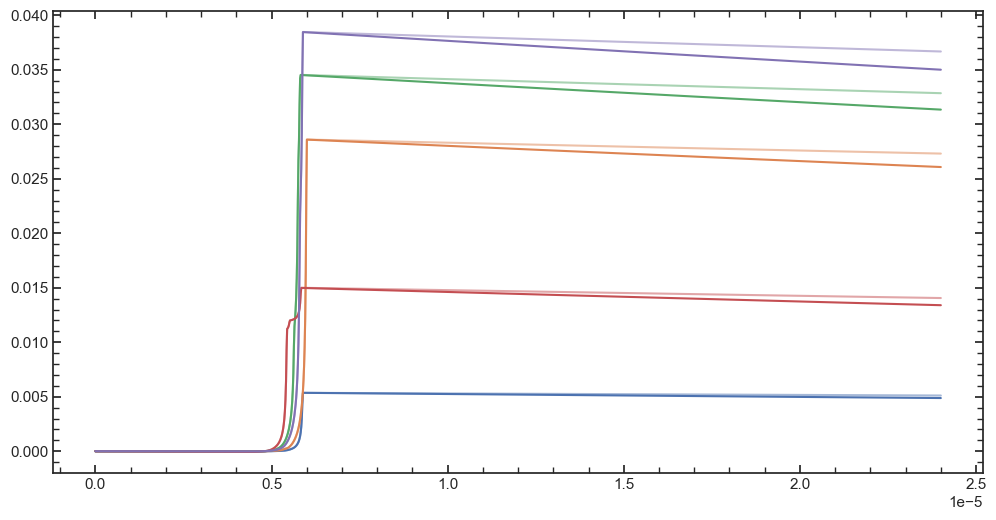

In [15]:

plt.figure(figsize=(12, 6))
for i in range(dimensions[0]):
    line1 = plt.plot(time, waveforms[i,:], label=f'Original {i+1}', alpha=0.5)
    color = line1[0].get_color()
    plt.plot(time, waveforms_with_freq[i,:], label=f'Filtered {i+1}', color=color)
